# Classifying Palmer Penguins

Chinstrap! 

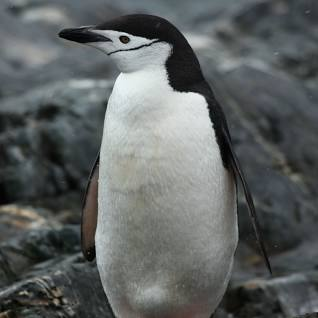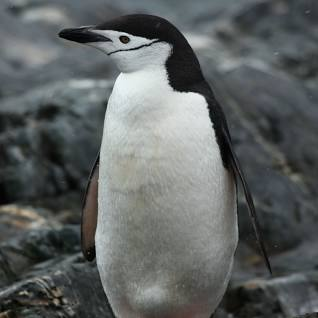

Gentoo!

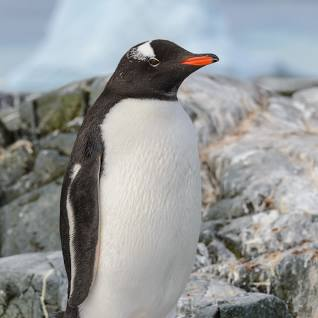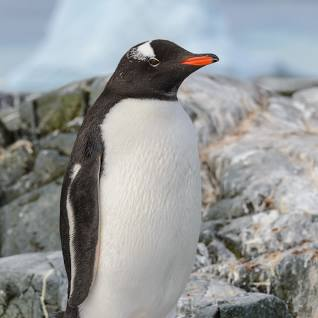

Adelie!

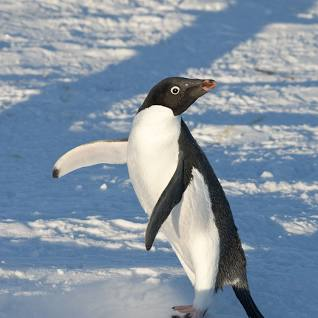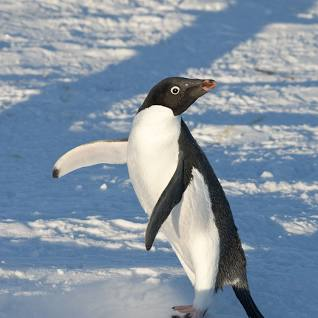

### Set up

Import required packages

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SequentialFeatureSelector
from matplotlib.patches import Patch

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, accuracy_score

Import dataset

In [2]:
train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

#train.head()

### Exploration

To begin, I will explore the penguins dataset by constructing a figure and a table. 

I will first create a dataframe so that I can better group data and create more informative charts 

In [3]:
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis = 1)
    #df = pd.get_dummies(df) #comment in for data analysis, out for table construction
    return df, y

X_train, y_train = prepare_data(train)

Before making some tables and figures, I am curious to run some basic statistics on the data 

In [4]:
species3pct = (y_train==2).mean()
species2pct = (y_train==1).mean()
species1pct = (y_train==0).mean() 
species3cnt = (y_train==2).sum()
species2cnt = (y_train==1).sum()
species1cnt = (y_train==0).sum()

print("There are approximately",species3cnt,"penguins in Species 3, or",species3pct.round(2)*100,"% of the penguins")
print("There are approximately",species2cnt,"penguins in Species 2, or",species2pct.round(2)*100,"% of the penguins")
print("There are approximately",species1cnt,"penguins in Species 1, or",species1pct.round(2)*100,"% of the penguins")

There are approximately 95 penguins in Species 3, or 37.0 % of the penguins
There are approximately 55 penguins in Species 2, or 21.0 % of the penguins
There are approximately 106 penguins in Species 1, or 41.0 % of the penguins


These numbers are the base rates for our model. The base rate is the accuracy rate of a trivial model that doesn’t use the features. It is the accuracy I would have if I made predictions without looking at the data. 

Next, I am curious in the following: 

- Where do the penguins live? 
- Does their flipper length/culmen length vary by sex or island? 
- Does weight vary by sex or island? 

In [5]:
X_train.groupby(["Island","Sex"])[['Body Mass (g)','Culmen Length (mm)','Flipper Length (mm)']].aggregate([np.mean]).round(2)

Body Mass (g) Culmen Length (mm) Flipper Length (mm)
                          mean               mean                mean
Island    Sex                                                        
Biscoe    FEMALE       4253.28              42.94              204.67
          MALE         5168.12              47.54              214.49
Dream     FEMALE       3435.20              42.45              190.08
          MALE         3973.30              46.64              196.73
Torgersen FEMALE       3371.88              37.46              189.50
          MALE         4016.18              40.88              195.65

In [6]:
X_train.groupby(["Island"])[['Body Mass (g)','Culmen Length (mm)','Flipper Length (mm)']].aggregate([np.mean]).round(2)


,Body Mass (g),Culmen Length (mm),Flipper Length (mm)
,mean,mean,mean
Island,,,
Biscoe,4738.85,45.38,209.88
Dream,3689.78,44.43,193.23
Torgersen,3703.79,39.22,192.67


In [7]:
X_train.groupby(["Island", "Sex"]).size().reset_index()

,Island,Sex,0
0,Biscoe,FEMALE,61
1,Biscoe,MALE,69
2,Dream,FEMALE,49
3,Dream,MALE,44
4,Torgersen,FEMALE,16
5,Torgersen,MALE,17


In [8]:
X_train.groupby(["Island"]).size().reset_index()

,Island,0
0,Biscoe,130
1,Dream,93
2,Torgersen,33


In [9]:
X_train.groupby(["Sex"])[['Body Mass (g)']].aggregate([len]).round(2)

,Body Mass (g)
,len
Sex,
FEMALE,126
MALE,130


I learned:
- females tend to weigh less than males 
- females generally have shorter beaks
- females generally have and shorter flippers. 
- there are slightly more males in the study 
- there are the most penguins on Biscoe island, then Dream, then Torgersen
- there are similar amounts of penguins of different sexes on the different islands
- Bisco island is home to penguins with heavier bodies, and longer beaks and flippers. 

Now I want to create a chart to better understand weight distributions of the penguins by island. 

[Text(0.5, 1.0, 'Body Mass by Island')]

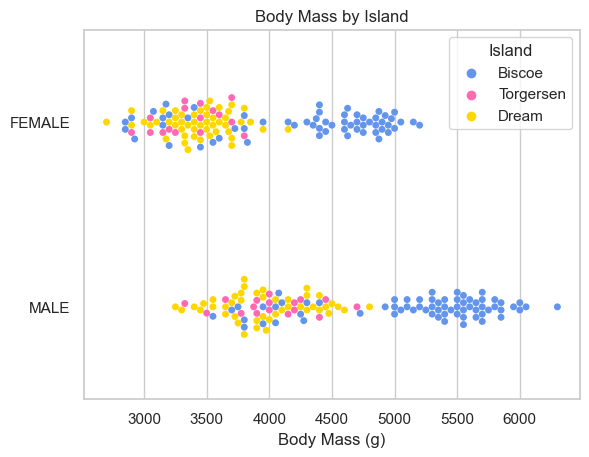

In [10]:
sns.set_theme(style="whitegrid", palette={"Gold","HotPink","CornflowerBlue"})

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=X_train, x='Body Mass (g)', y="Sex", hue="Island")
ax.set(ylabel="")
ax.set(title = "Body Mass by Island")

[Text(0.5, 1.0, 'Flipper Length by Island')]

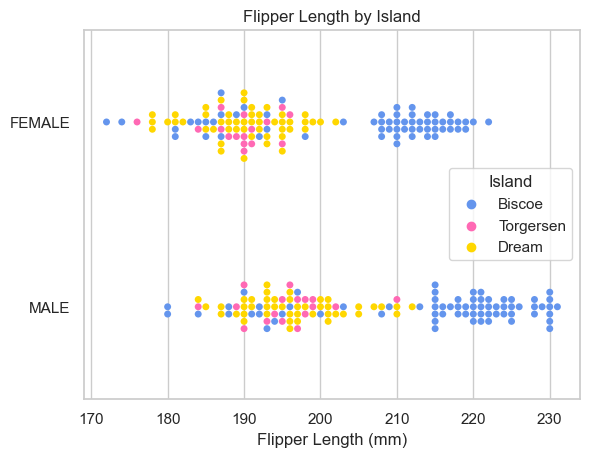

In [11]:
sns.set_theme(style="whitegrid", palette={"Gold","HotPink","CornflowerBlue"})

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=X_train, x='Flipper Length (mm)', y="Sex", hue="Island")
ax.set(ylabel="")
ax.set(title = "Flipper Length by Island")

[Text(0.5, 1.0, 'Culmen Length by Island')]

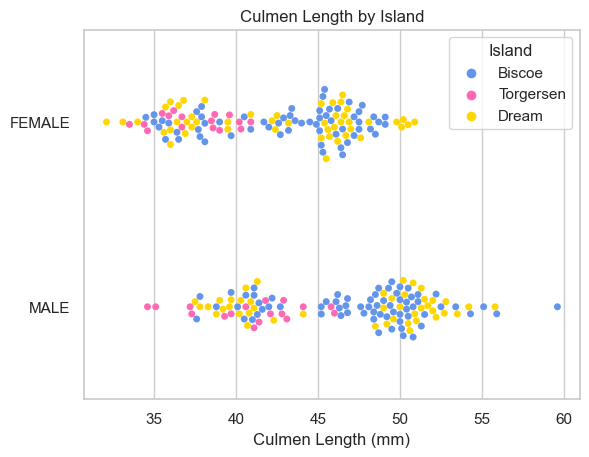

In [12]:
sns.set_theme(style="whitegrid", palette={"Gold","HotPink","CornflowerBlue"})

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=X_train, x='Culmen Length (mm)', y="Sex", hue="Island")
ax.set(ylabel="")
ax.set(title = "Culmen Length by Island")

While Biscoe island defintly hosts penguins with more mass and longer flippers, the same is not necessarily true for beak (Culmen) length. The male/female distinction does not appear to make a difference island by island. 

### Implementation

First, modify the dataframe using pd.get_dummies to encode nominal data

In [13]:
def prepare_data2(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis = 1)
    df = pd.get_dummies(df) #comment in for data analysis, out for table construction
    return df, y

X_train2, y_train2 = prepare_data2(train)

Our first task is to find three features of the data and a model trained on those features which achieves 100% testing accuracy
- One feature must be qualitative (like Island or Clutch Completion).
- The other two features must be quantitative (like Body Mass (g) or Culmen Depth (mm)).

First, lets figure out what features are best. 

### Feature Selection

After some experimenting, I decided to select the optimal features from a model. 

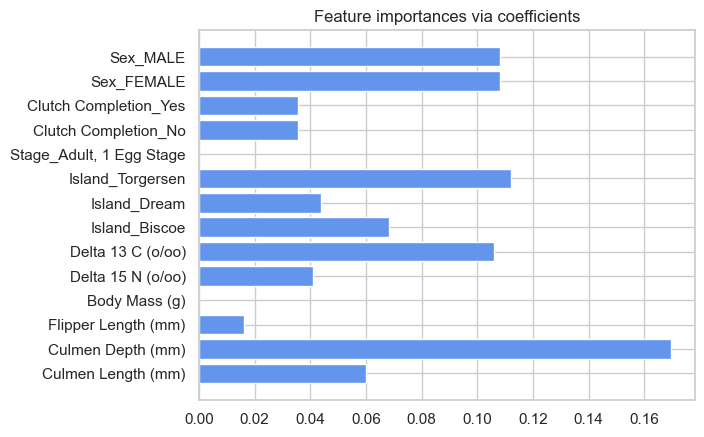

['Culmen Depth (mm)' 'Delta 13 C (o/oo)' 'Island_Torgersen']
Features selected by SelectFromModel: ['Culmen Depth (mm)' 'Delta 13 C (o/oo)' 'Island_Torgersen']


In [14]:

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train2, y_train2) #Ridge regression with built-in cross-validation.
importance = np.abs(ridge.coef_) # assign importance to each feature through a specific attribute
#The features with the highest absolute coef_ value are considered the most important

#create a plot to visualize the importance of the features
feature_names = np.array(X_train2.columns)
plt.barh(feature_names, importance)
plt.title("Feature importances via coefficients")
plt.show()

#select a certain number of features
threshold = np.sort(importance)[-5]

sfm = SelectFromModel(ridge, threshold=threshold).fit(X_train2, y_train2)
#only select the first three features from the list
selected_features = feature_names[sfm.get_support()][0:3]

print(selected_features)
print(f"Features selected by SelectFromModel: {selected_features}")

Using the select by model method, Culmen Depth, Delta 13 C and Island_Torgersen are the most important for correct classification of penguins. However, both Sex_Female and Sex_Male rank higher than both Island_Dream and Island_Biscoe. So I experimented with using sex instead of island. 

### Model Selection

I will first explore how well linear regression works for this data, and then experiment with DecisionTreeClassifier and RandomForestClassifier.

#### Logistic Regression

In [23]:
#change selected features to invlude Island_Dream and Island_Biscoe as well 
features_to_test = X_train2[selected_features].join(X_train2["Island_Dream"]).join(X_train2["Island_Biscoe"])
LR = LogisticRegression(random_state = 10, max_iter = 1000)
LR.fit(features_to_test, y_train2)

LR.score(features_to_test, y_train2)

0.93359375

Logistic regression is 93% accurate on the training data. 

### Testing

Now, we will evaluate the model's efficacy on the test data

In [31]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

def prepare_data3(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis = 1)
    df = pd.get_dummies(df) #comment in for data analysis, out for table construction
    return df, y

X_test, y_test = prepare_data3(test)
# print(X_test)
# print(y_test)

features_to_test2 = X_test[selected_features].join(X_test["Island_Dream"]).join(X_test["Island_Biscoe"])

LR.fit(features_to_test2, y_test)
LR.score(features_to_test2, y_test)

0.9411764705882353

The model is slightly more effective on the test data, at 94%. In the two cells below, I experiment with different parameters to allow for this particular model to reach 100% accuracy on the test data. 

In [32]:
#change selected features to invlude Island_Dream and Island_Biscoe as well 
features_to_test_extra = ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Island_Torgersen', "Island_Dream", "Island_Biscoe"]
LR_extra = LogisticRegression(random_state = 10, max_iter = 1000)
LR_extra.fit(X_train2[features_to_test_extra], y_train2)

LR_extra.score(X_train2[features_to_test_extra], y_train2)

0.99609375

In [33]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

def prepare_data3(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis = 1)
    df = pd.get_dummies(df) #comment in for data analysis, out for table construction
    return df, y

X_test, y_test = prepare_data3(test)
# print(X_test)
# print(y_test)

# features_to_test2 = X_test[selected_features].join(X_test["Island_Dream"]).join(X_test["Island_Biscoe"])
features_to_test2_extra = ['Culmen Depth (mm)', 'Culmen Length (mm)', 'Island_Torgersen', "Island_Dream", "Island_Biscoe"]

LR_extra.fit(X_test[features_to_test2_extra], y_test)
LR_extra.score(X_test[features_to_test2_extra], y_test)

1.0

When I changed my selected features to Culmen Depth (mm), Culment Length (mm), Island_Torgersen, Island_Dream, Island_Biscoe, the model achieved 100% accuracy on the test data. I will not plot this data, but it is nice that some selected features allow for this model to reach 100% accuracy, just not the features chosen by the "Select by Model" classification system. 

### Evaluation

now we will plot the decision regions, seperated by qualitative feature (Island: Torgersen, Dream, Biscoe) 

In [34]:
def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]

    fig, axarr = plt.subplots(1, len(qual_features), figsize = (15, 3)) #maybe put 1 there

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
        XY = pd.DataFrame({
            X.columns[0] : XX,
            X.columns[1] : YY
        })

        for j in qual_features:
            XY[j] = 0

        XY[qual_features[i]] = 1

        p = model.predict(XY)
        p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
        axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
        ix = X[qual_features[i]] == 1
      # plot the data
        axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
        axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
        patches = []
        for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
            patches.append(Patch(color = color, label = spec))

        plt.legend(title = "Species", handles = patches, loc = "best")
      
        plt.tight_layout()

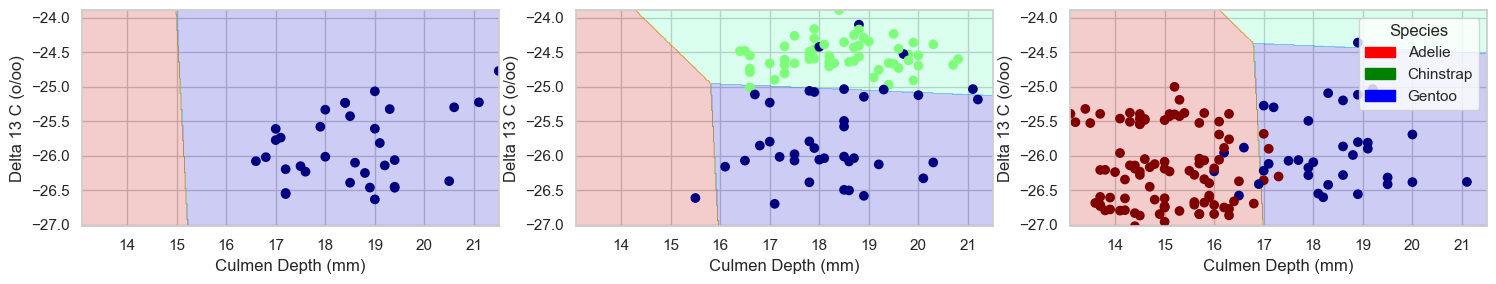

In [35]:
plot_regions(LR, features_to_test, y_train2)

Next, we will experiment with a couple other classifiers. 

#### Decision Tree Classifier

In [38]:
dtc = DecisionTreeClassifier(max_depth=5)

cross_val_score(dtc, features_to_test, y_train2, cv=5)

array([0.92307692, 0.92156863, 0.84313725, 0.90196078, 0.90196078])

In [39]:
dtc.fit(features_to_test, y_train2, sample_weight=None, check_input=True)

dtc.score(features_to_test, y_train2, sample_weight=None)

0.96875

This model is more effective than regression on the training data. 

##### Test

In [40]:
dtc.fit(features_to_test2, y_test, sample_weight=None, check_input=True)

dtc.score(features_to_test2, y_test)

0.9852941176470589

It is also more effective than regression on the test data. 

##### Plot regions 

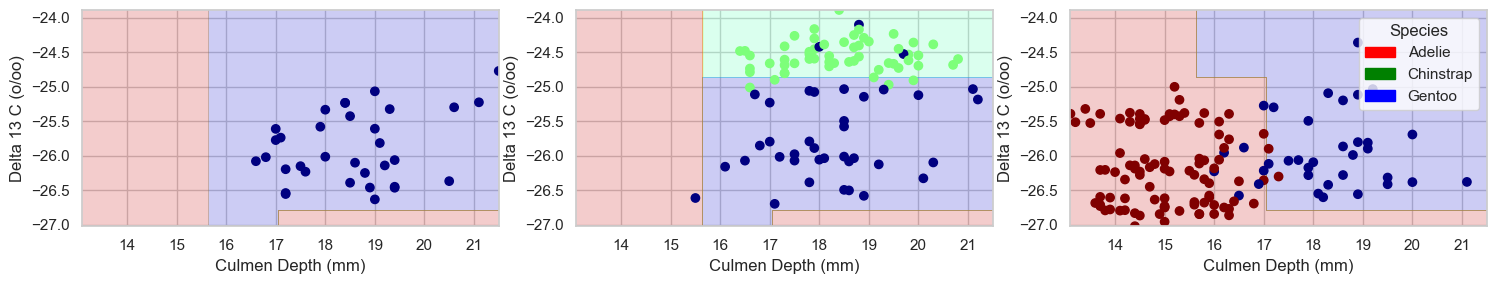

In [41]:
plot_regions(dtc, features_to_test, y_train2)

This model uses more advanced geometries to separate the data

#### Random Forest Classifier

Let's look at one more type of classifier! 

In [42]:
rfc = RandomForestClassifier(max_depth=7, random_state=1)
rfc.fit(features_to_test, y_train2)

rfc.apply(features_to_test)
rfc.score(features_to_test, y_train2, sample_weight=None)

0.99609375

This model is incredibly effective for the chosen parameters! 

##### Test

In [43]:
rfc.fit(features_to_test2, y_test)

rfc.score(features_to_test2, y_test)

1.0

This model achieves 100% testing accuracy, making it the best choice for the features chosen by the select from model classificiation. 

##### Plot regions 

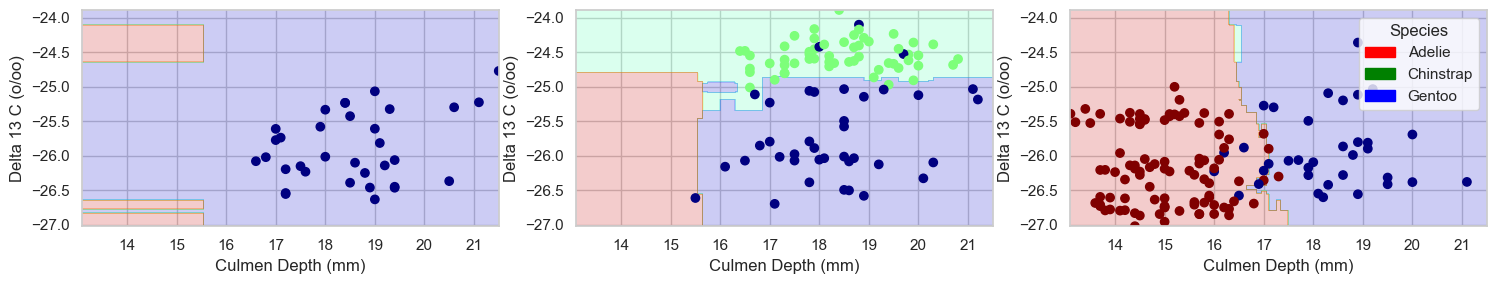

In [44]:
plot_regions(rfc, features_to_test, y_train2)

This model also uses complex geometries, but is the superior choice in classifying the penguins for the selected features. 